# Fed Averserial and Scaffold

# Importing Libraries

In [ ]:
import os
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
seed = 42 # Set a fixed seed for reproducibility
random.seed(seed) # Python's built-in random module
np.random.seed(seed) # NumPy
torch.manual_seed(seed) # PyTorch
torch.cuda.manual_seed(seed) # If using CUDA
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# # Ensure deterministic behavior (can slow down performance)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Loading Dataset

In [ ]:
# Define transformation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

def load_cifar10(transform, root='./data', train=True):
    return datasets.CIFAR10(root=root, train=train, download=True, transform=transform)

def split_dataset(dataset, train_ratio=0.8): # Split dataset into training and testing subsets
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size

    train_indices = list(range(train_size))
    test_indices = list(range(train_size, dataset_size))

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, test_dataset

def subset_to_numpy(dataset, subset): # Convert Subsets to numpy arrays
    images = dataset.data[subset.indices]
    labels = np.array(dataset.targets)[subset.indices]
    return images, labels


CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
cifar10_dataset = load_cifar10(transform=transform)
train_dataset, test_dataset = split_dataset(cifar10_dataset)

train_images, train_labels = subset_to_numpy(cifar10_dataset, train_dataset)
test_images, test_labels = subset_to_numpy(cifar10_dataset, test_dataset)

print(f"Dataset size: {len(cifar10_dataset)}")
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

# Optionally create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:18<00:00, 9.17MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset size: 50000
Train images shape: (40000, 32, 32, 3), Train labels shape: (40000,)
Test images shape: (10000, 32, 32, 3), Test labels shape: (10000,)


In [ ]:
# Define transformation for MNIST
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),  # MNIST images are already 28x28
    # transforms.Normalize((0.5,), (0.5,))  # Uncomment for normalization
])

# Define function to load MNIST dataset
def load_mnist(transform, root='./data', train=True):
    return datasets.MNIST(root=root, train=train, download=True, transform=mnist_transform)

# Define MNIST classes
MNIST_CLASSES = tuple(str(i) for i in range(10))  # 0-9 digits

In [ ]:
mnist_dataset = load_mnist(mnist_transform, train=True)
mnist_train, mnist_test = split_dataset(mnist_dataset)

# Convert training subset to numpy arrays
train_images, train_labels = subset_to_numpy(mnist_dataset, mnist_train)
test_images, test_labels = subset_to_numpy(mnist_dataset, mnist_test)

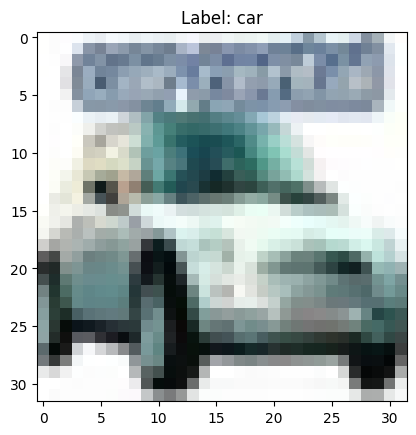

In [ ]:
#display an image along with its label
idx = 0
image = test_images[idx]
label = test_labels[idx]
name_label = CLASSES[label]
plt.imshow(image)
plt.title(f"Label: {name_label}")
plt.show()

# Partitioning Dataset

In [ ]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32, seed=42):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]

        # Set the seed again before generating proportions for this class
        np.random.seed(seed + c)  # Adding `c` ensures unique seeds for each class
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]

        # Set the seed again before generating proportions for this class
        np.random.seed(seed + c + 1000)  # Adding an offset ensures unique seeds for test data
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        # client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)

        if len(train_data.shape) == 3:  # Grayscale
            client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        else:  # RGB
            client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]

        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=True, drop_last=False)
        federated_train_loaders.append(train_loader)

        # client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        if len(test_data.shape) == 3:  # Grayscale
            client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        else:  # RGB
            client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


#Setting up Model

In [ ]:
class SimpleCNN(nn.Module): #this is same as TINY VGG model
    def __init__(self, filters=64, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Block 1
        self.conv_1_1 = nn.Conv2d(3, filters, kernel_size=3, padding=1)  # Input: 3x32x32 -> Output: filters x 32 x 32
        self.relu_1_1 = nn.ReLU()
        self.conv_1_2 = nn.Conv2d(filters, filters, kernel_size=3, padding=1)  # Output: filters x 32 x 32
        self.relu_1_2 = nn.ReLU()
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters x 16 x 16

        # Block 2
        self.conv_2_1 = nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 16 x 16
        self.relu_2_1 = nn.ReLU()
        self.conv_2_2 = nn.Conv2d(filters * 2, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 16 x 16
        self.relu_2_2 = nn.ReLU()
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters*2 x 8 x 8

        # Block 3
        self.conv_3_1 = nn.Conv2d(filters * 2, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 8 x 8
        self.relu_3_1 = nn.ReLU()
        self.conv_3_2 = nn.Conv2d(filters * 4, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 8 x 8
        self.relu_3_2 = nn.ReLU()
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters*4 x 4 x 4

        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(filters * 4 * 4 * 4, num_classes)  # Output: 10 classes (CIFAR-10)
        # self.fc = nn.Linear(filters * 36, num_classes)  # Output: 10 classes (MNIST)

    def forward(self, x):
        # Block 1
        x = self.relu_1_1(self.conv_1_1(x))
        x = self.relu_1_2(self.conv_1_2(x))
        x = self.max_pool_1(x)

        # Block 2
        x = self.relu_2_1(self.conv_2_1(x))
        x = self.relu_2_2(self.conv_2_2(x))
        x = self.max_pool_2(x)

        # Block 3
        x = self.relu_3_1(self.conv_3_1(x))
        x = self.relu_3_2(self.conv_3_2(x))
        x = self.max_pool_3(x)

        # Flatten and Fully Connected Layer
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def get_latents(self, x):
        # Extract feature latents before the final fully connected layer
        x = self.relu_1_1(self.conv_1_1(x))
        x = self.relu_1_2(self.conv_1_2(x))
        x = self.max_pool_1(x)

        x = self.relu_2_1(self.conv_2_1(x))
        x = self.relu_2_2(self.conv_2_2(x))
        x = self.max_pool_2(x)

        x = self.relu_3_1(self.conv_3_1(x))
        x = self.relu_3_2(self.conv_3_2(x))
        x = self.max_pool_3(x)

        x = self.flatten(x)
        latents = x  # Latent features before the final output layer
        # print(f"Latent Features Shape: {latents.shape}")
        return latents

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size=4096, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, h):
        y = self.layer(h)
        return y


model = SimpleCNN().to(device)
summary(model, (3, 32, 32))  # Pass input shape (channels, height, width) instead of the tensor

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

# FED AVERAGE

In [ ]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy

In [ ]:
# Server-side Federated Averaging
def fedavg_training(adverserial, global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    discriminators = {}
    global_model = global_model.to(device)

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):

            if adverserial:
              client_id = i
              update = local_train_adversarial(global_model, train_loaders[i], epochs, lr, client_id, discriminators)
            else:
              update = local_train(global_model, train_loaders[i], epochs, lr)

            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


# Client-side local training
def local_train(model, train_loader, epochs, lr):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    # for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels  = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update

def local_train_adversarial(model, train_loader, epochs, lr, client_id, discriminators):
    """
    Train a local model with adversarial feature matching.

    Args:
        model (nn.Module): The global model to initialize local training.
        train_loader (DataLoader): DataLoader for the client's training data.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.
        client_id (int): Unique identifier for the client.
        discriminators (dict): Dictionary of discriminators for each client.

    Returns:
        dict: Dictionary of model updates (local model - global model).
    """
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()
    model.eval()  # Ensure the global model remains in evaluation mode

    criterion = nn.CrossEntropyLoss()
    adv_criterion = nn.MSELoss()  # Loss for adversarial feature matching

    # Retrieve the discriminator for this client
    if client_id not in discriminators:
        # Initialize a new discriminator for this client if not already present
        discriminators[client_id] = Discriminator().to(device)  # Adjust input_size to match latent dimensions

    discriminator = discriminators[client_id]
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(local_model.parameters(), lr=lr)

    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            # Extract latents from both models
            global_latents = model.get_latents(data).detach()  # Detach to prevent gradient flow
            local_latents = local_model.get_latents(data)

            # Train Discriminator
            discriminator.train()
            real_preds = discriminator(global_latents)  # Real latents (from the global model)
            fake_preds = discriminator(local_latents.detach())  # Fake latents (from the local model)
            real_labels = torch.ones_like(real_preds).to(device)
            fake_labels = torch.zeros_like(fake_preds).to(device)

            d_loss_real = nn.BCELoss()(real_preds, real_labels)
            d_loss_fake = nn.BCELoss()(fake_preds, fake_labels)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Local Model (Generator)
            discriminator.eval()
            fake_preds = discriminator(local_latents)
            classification_loss = criterion(local_model(data), labels)
            adversarial_loss = -torch.mean(fake_preds)  # Generator tries to fool the discriminator
            feature_matching_loss = adv_criterion(local_latents, global_latents)

            total_loss = classification_loss + 0.1 * feature_matching_loss + 0.1 * adversarial_loss  # Adjust weights as needed

            g_optimizer.zero_grad()
            total_loss.backward()
            g_optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update


In [ ]:
# HyperParameters
num_clients = 5
batch_size = 128
rounds = 15
epochs = 5
lr = 0.001
dirichlet_alphas = [0.5]
accuracies_per_alpha = {
    alpha: [] for alpha in dirichlet_alphas
}


def run_fedavg(alpha):
    round_accuracies_fedavg, round_accuracies_fedavg_adv = 0, 0
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)

    Adverserial = False
    global_model_fedavg = SimpleCNN()
    _, round_accuracies_fedavg = fedavg_training(Adverserial,
                                          global_model_fedavg,
                                          train_loaders,
                                          num_clients,
                                          rounds=rounds,
                                          epochs=epochs,
                                          lr=lr,
                                          test_loaders=test_loaders)

    Adverserial = True
    global_model_fedavg_adv = SimpleCNN()
    _, round_accuracies_fedavg_adv = fedavg_training(Adverserial,
                                          global_model_fedavg_adv,
                                          train_loaders,
                                          num_clients,
                                          rounds=rounds,
                                          epochs=epochs,
                                          lr=lr,
                                          test_loaders=test_loaders)

    return round_accuracies_fedavg ,round_accuracies_fedavg_adv

In [ ]:
alpha = 0.5
round_accuracies_fedavg, round_accuracies_fedavg_adv = run_fedavg(alpha)
accuracies_per_alpha[alpha].append(round_accuracies_fedavg)

Communication Rounds:   7%|▋         | 1/15 [00:35<08:20, 35.72s/it]

Round 1 Accuracy: 0.1016



Communication Rounds:  13%|█▎        | 2/15 [01:10<07:40, 35.42s/it]

Round 2 Accuracy: 0.2805



Communication Rounds:  20%|██        | 3/15 [01:46<07:03, 35.33s/it]

Round 3 Accuracy: 0.5640



Communication Rounds:  27%|██▋       | 4/15 [02:21<06:28, 35.35s/it]

Round 4 Accuracy: 0.6546



Communication Rounds:  33%|███▎      | 5/15 [02:56<05:53, 35.32s/it]

Round 5 Accuracy: 0.6661



Communication Rounds:  40%|████      | 6/15 [03:32<05:17, 35.32s/it]

Round 6 Accuracy: 0.6809



Communication Rounds:  47%|████▋     | 7/15 [04:07<04:42, 35.32s/it]

Round 7 Accuracy: 0.6878



Communication Rounds:  53%|█████▎    | 8/15 [04:42<04:07, 35.30s/it]

Round 8 Accuracy: 0.6888



Communication Rounds:  60%|██████    | 9/15 [05:17<03:31, 35.27s/it]

Round 9 Accuracy: 0.6908



Communication Rounds:  67%|██████▋   | 10/15 [05:53<02:56, 35.28s/it]

Round 10 Accuracy: 0.6850



Communication Rounds:  73%|███████▎  | 11/15 [06:28<02:21, 35.28s/it]

Round 11 Accuracy: 0.6916



Communication Rounds:  80%|████████  | 12/15 [07:03<01:45, 35.28s/it]

Round 12 Accuracy: 0.6895



Communication Rounds:  87%|████████▋ | 13/15 [07:38<01:10, 35.27s/it]

Round 13 Accuracy: 0.6910



Communication Rounds:  93%|█████████▎| 14/15 [08:14<00:35, 35.25s/it]

Round 14 Accuracy: 0.6947



Communication Rounds: 100%|██████████| 15/15 [08:49<00:00, 35.30s/it]


Round 15 Accuracy: 0.6895


Communication Rounds:   7%|▋         | 1/15 [01:22<19:12, 82.32s/it]

Round 1 Accuracy: 0.0957



Communication Rounds:  13%|█▎        | 2/15 [02:44<17:50, 82.32s/it]

Round 2 Accuracy: 0.2412



Communication Rounds:  20%|██        | 3/15 [04:06<16:27, 82.33s/it]

Round 3 Accuracy: 0.5650



Communication Rounds:  27%|██▋       | 4/15 [05:29<15:06, 82.38s/it]

Round 4 Accuracy: 0.6702



Communication Rounds:  33%|███▎      | 5/15 [06:51<13:44, 82.40s/it]

Round 5 Accuracy: 0.7044



Communication Rounds:  40%|████      | 6/15 [08:14<12:21, 82.44s/it]

Round 6 Accuracy: 0.7143



Communication Rounds:  47%|████▋     | 7/15 [09:36<10:59, 82.47s/it]

Round 7 Accuracy: 0.7221



Communication Rounds:  53%|█████▎    | 8/15 [10:59<09:37, 82.50s/it]

Round 8 Accuracy: 0.7264



Communication Rounds:  60%|██████    | 9/15 [12:21<08:15, 82.50s/it]

Round 9 Accuracy: 0.7301



Communication Rounds:  67%|██████▋   | 10/15 [13:44<06:52, 82.52s/it]

Round 10 Accuracy: 0.7259



Communication Rounds:  73%|███████▎  | 11/15 [15:07<05:30, 82.50s/it]

Round 11 Accuracy: 0.7268



Communication Rounds:  80%|████████  | 12/15 [16:29<04:07, 82.48s/it]

Round 12 Accuracy: 0.7300



Communication Rounds:  87%|████████▋ | 13/15 [17:52<02:45, 82.58s/it]

Round 13 Accuracy: 0.7323



Communication Rounds:  93%|█████████▎| 14/15 [19:14<01:22, 82.53s/it]

Round 14 Accuracy: 0.7323



Communication Rounds: 100%|██████████| 15/15 [20:36<00:00, 82.46s/it]

Round 15 Accuracy: 0.7342


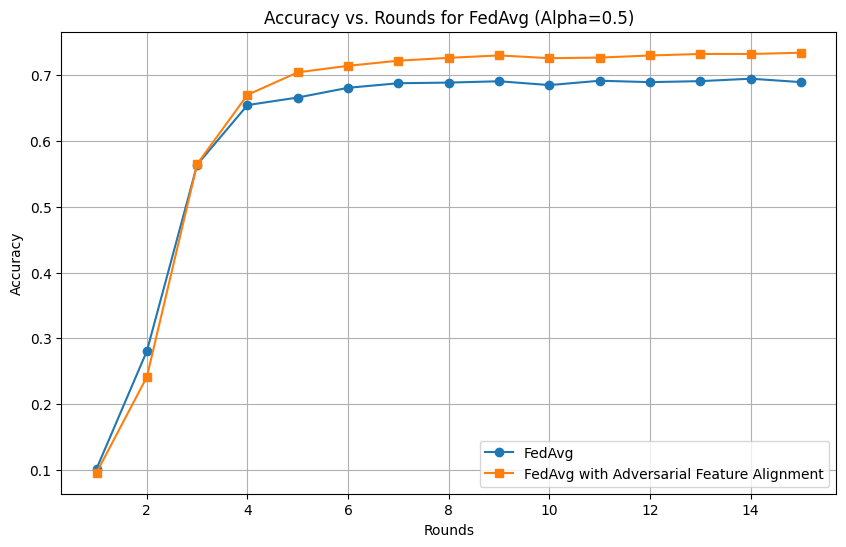

In [ ]:
alpha = 0.5
accuracies = accuracies_per_alpha[alpha]
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg,round_accuracies_fedavg_adv)

# Extract the FedAvg and FedAvg Adv accuracies
plot_round_accuracies_fedavg = round_accuracies_fedavg
plot_round_accuracies_fedavg_adv = round_accuracies_fedavg_adv

# Number of rounds
num_rounds = len(plot_round_accuracies_fedavg)
rounds = range(1, num_rounds + 1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, plot_round_accuracies_fedavg, label='FedAvg', marker='o')
plt.plot(rounds, plot_round_accuracies_fedavg_adv, label='FedAvg with Adversarial Feature Alignment', marker='s')

# Add labels, title, and legend
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Rounds for FedAvg (Alpha={alpha})")
plt.legend()
plt.grid(True)
plt.show()

# With alpha = 2

In [ ]:
alpha = 2
round_accuracies_fedavg, round_accuracies_fedavg_adv = run_fedavg(alpha)
accuracies_per_alpha[alpha].append(round_accuracies_fedavg)

Communication Rounds:   7%|▋         | 1/15 [00:36<08:26, 36.20s/it]

Round 1 Accuracy: 0.0998



Communication Rounds:  13%|█▎        | 2/15 [01:12<07:51, 36.30s/it]

Round 2 Accuracy: 0.3912



Communication Rounds:  20%|██        | 3/15 [01:48<07:15, 36.26s/it]

Round 3 Accuracy: 0.6464



Communication Rounds:  27%|██▋       | 4/15 [02:25<06:39, 36.31s/it]

Round 4 Accuracy: 0.6993



Communication Rounds:  33%|███▎      | 5/15 [03:01<06:03, 36.32s/it]

Round 5 Accuracy: 0.7163



Communication Rounds:  40%|████      | 6/15 [03:37<05:26, 36.30s/it]

Round 6 Accuracy: 0.7319



Communication Rounds:  47%|████▋     | 7/15 [04:14<04:50, 36.30s/it]

Round 7 Accuracy: 0.7349



Communication Rounds:  53%|█████▎    | 8/15 [04:50<04:14, 36.30s/it]

Round 8 Accuracy: 0.7378



Communication Rounds:  60%|██████    | 9/15 [05:26<03:37, 36.29s/it]

Round 9 Accuracy: 0.7351



Communication Rounds:  67%|██████▋   | 10/15 [06:02<03:01, 36.28s/it]

Round 10 Accuracy: 0.7416



Communication Rounds:  73%|███████▎  | 11/15 [06:39<02:25, 36.27s/it]

Round 11 Accuracy: 0.7407



Communication Rounds:  80%|████████  | 12/15 [07:15<01:48, 36.25s/it]

Round 12 Accuracy: 0.7439



Communication Rounds:  87%|████████▋ | 13/15 [07:51<01:12, 36.22s/it]

Round 13 Accuracy: 0.7400



Communication Rounds:  93%|█████████▎| 14/15 [08:27<00:36, 36.21s/it]

Round 14 Accuracy: 0.7468



Communication Rounds: 100%|██████████| 15/15 [09:03<00:00, 36.26s/it]


Round 15 Accuracy: 0.7444


Communication Rounds:   7%|▋         | 1/15 [01:24<19:44, 84.63s/it]

Round 1 Accuracy: 0.0997



Communication Rounds:  13%|█▎        | 2/15 [02:49<18:18, 84.49s/it]

Round 2 Accuracy: 0.4767



Communication Rounds:  20%|██        | 3/15 [04:13<16:54, 84.53s/it]

Round 3 Accuracy: 0.6860



Communication Rounds:  27%|██▋       | 4/15 [05:38<15:30, 84.61s/it]

Round 4 Accuracy: 0.7363



Communication Rounds:  33%|███▎      | 5/15 [07:03<14:06, 84.68s/it]

Round 5 Accuracy: 0.7541



Communication Rounds:  40%|████      | 6/15 [08:27<12:42, 84.70s/it]

Round 6 Accuracy: 0.7583



Communication Rounds:  47%|████▋     | 7/15 [09:52<11:17, 84.73s/it]

Round 7 Accuracy: 0.7641



Communication Rounds:  53%|█████▎    | 8/15 [11:17<09:53, 84.73s/it]

Round 8 Accuracy: 0.7629



Communication Rounds:  60%|██████    | 9/15 [12:42<08:28, 84.72s/it]

Round 9 Accuracy: 0.7674



Communication Rounds:  67%|██████▋   | 10/15 [14:06<07:03, 84.68s/it]

Round 10 Accuracy: 0.7690



Communication Rounds:  73%|███████▎  | 11/15 [15:31<05:38, 84.66s/it]

Round 11 Accuracy: 0.7711



Communication Rounds:  80%|████████  | 12/15 [16:55<04:13, 84.64s/it]

Round 12 Accuracy: 0.7721



Communication Rounds:  87%|████████▋ | 13/15 [18:20<02:49, 84.59s/it]

Round 13 Accuracy: 0.7680



Communication Rounds:  93%|█████████▎| 14/15 [19:44<01:24, 84.57s/it]

Round 14 Accuracy: 0.7782



Communication Rounds: 100%|██████████| 15/15 [21:09<00:00, 84.62s/it]

Round 15 Accuracy: 0.7740


KeyError: 2

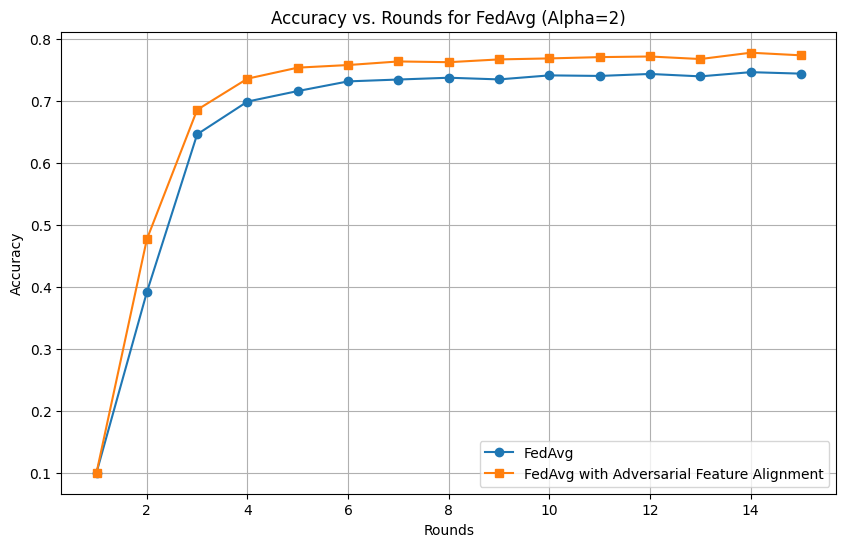

In [ ]:
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg)
alpha = 2
# accuracies = accuracies_per_alpha[alpha]
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg,round_accuracies_fedavg_adv)

# Extract the FedAvg and FedAvg Adv accuracies
plot_round_accuracies_fedavg = round_accuracies_fedavg
plot_round_accuracies_fedavg_adv = round_accuracies_fedavg_adv

# Number of rounds
num_rounds = len(plot_round_accuracies_fedavg)
rounds = range(1, num_rounds + 1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, plot_round_accuracies_fedavg, label='FedAvg', marker='o')
plt.plot(rounds, plot_round_accuracies_fedavg_adv, label='FedAvg with Adversarial Feature Alignment', marker='s')

# Add labels, title, and legend
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Rounds for FedAvg (Alpha={alpha})")
plt.legend()
plt.grid(True)
plt.show()

# SCAFFOLD

In [ ]:
def fedavg_training_new(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders, align=None):
    round_avg_updates = []
    round_accuracies = []
    discriminators = {}
    global_model = global_model.to(device)

    # Initialize control variates
    global_control_variate = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
    client_control_variates = [
        {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for _ in range(num_clients)
    ]

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            if align == "Adverserial":
                client_id = i
                update = local_train_adversarial_scaffold(global_model, train_loaders[i], epochs, lr, client_id, client_control_variates[i], global_control_variate, discriminators)
            elif align == "SCAFFOLD":
                # SCAFFOLD-specific update for local model training
                update =             local_train_scaffold(global_model, train_loaders[i], epochs, lr, client_control_variates[i], global_control_variate)
            else:
                update = local_train(global_model, train_loaders[i], epochs, lr)

            # Store the update
            client_updates.append(update)

        # Average updates from all clients
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Update the global control variate if using SCAFFOLD
        if align == "SCAFFOLD":
            global_control_variate = {name: global_control_variate[name] +
                                      (sum(client_control_variates[i][name] for i in range(num_clients)) / num_clients)
                                      for name in global_control_variate.keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


def local_train_scaffold(global_model, train_loader, epochs, lr, client_control_variate, global_control_variate):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(global_model)
    local_model.load_state_dict(global_model.state_dict())

    local_model = local_model.to(device)
    global_model = global_model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_model(data)
            loss = criterion(outputs, labels)
            loss.backward()

            # Compute gradients (local update)
            local_update = {name: param.grad for name, param in local_model.named_parameters()}

            # Adjust with control variates
            adjusted_update = {
                name: local_update[name] - client_control_variate[name] + global_control_variate[name]
                for name in local_update.keys()
            }

            # Apply adjusted gradients
            for name, param in local_model.named_parameters():
                param.grad = adjusted_update[name]

            optimizer.step()

    # Compute the overall update: difference between the global model and local model
    overall_update = {name: param.data - global_model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    # Update the client control variate based on the local model update
    client_control_variate = {
        name: overall_update[name] - global_model.state_dict()[name]
        for name in overall_update.keys()
    }

    return overall_update


def local_train_adversarial_scaffold(global_model, train_loader, epochs, lr, client_id, client_control_variate, global_control_variate, discriminators):
    """
    Train a local model with adversarial feature matching and scaffold-based updates.

    Args:
        global_model (nn.Module): The global model to initialize local training.
        train_loader (DataLoader): DataLoader for the client's training data.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.
        client_id (int): Unique identifier for the client.
        client_control_variate (dict): Control variates for the client.
        global_control_variate (dict): Control variates from the global model.
        discriminators (dict): Dictionary of discriminators for each client.

    Returns:
        dict: Dictionary of model updates (local model - global model).
    """
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(global_model)
    local_model.load_state_dict(global_model.state_dict())

    local_model = local_model.to(device)
    global_model = global_model.to(device)

    local_model.train()
    global_model.eval()  # Ensure the global model remains in evaluation mode

    criterion = nn.CrossEntropyLoss()
    adv_criterion = nn.MSELoss()  # Loss for adversarial feature matching

    # Retrieve the discriminator for this client
    if client_id not in discriminators:
        # Initialize a new discriminator for this client if not already present
        discriminators[client_id] = Discriminator().to(device)  # Adjust input_size to match latent dimensions

    discriminator = discriminators[client_id]
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(local_model.parameters(), lr=lr)

    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            # Extract latents from both models
            global_latents = global_model.get_latents(data).detach()  # Detach to prevent gradient flow
            local_latents = local_model.get_latents(data)

            # Train Discriminator
            discriminator.train()
            real_preds = discriminator(global_latents)  # Real latents (from the global model)
            fake_preds = discriminator(local_latents.detach())  # Fake latents (from the local model)
            real_labels = torch.ones_like(real_preds).to(device)
            fake_labels = torch.zeros_like(fake_preds).to(device)

            d_loss_real = nn.BCELoss()(real_preds, real_labels)
            d_loss_fake = nn.BCELoss()(fake_preds, fake_labels)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Local Model (Generator)
            discriminator.eval()
            fake_preds = discriminator(local_latents)
            classification_loss = criterion(local_model(data), labels)
            adversarial_loss = -torch.mean(fake_preds)  # Generator tries to fool the discriminator
            feature_matching_loss = adv_criterion(local_latents, global_latents)

            total_loss = classification_loss + 0.1 * feature_matching_loss + 0.1 * adversarial_loss  # Adjust weights as needed

            g_optimizer.zero_grad()
            total_loss.backward()

            # Apply Scaffold Update: Adjust gradients using control variates
            local_update = {name: param.grad for name, param in local_model.named_parameters()}

            adjusted_update = {
                name: local_update[name] - client_control_variate[name] + global_control_variate[name]
                for name in local_update.keys()
            }

            # Apply adjusted gradients
            for name, param in local_model.named_parameters():
                param.grad = adjusted_update[name]

            g_optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - global_model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    # Update the client control variate based on the local model update
    client_control_variate = {
        name: overall_update[name] - global_model.state_dict()[name]
        for name in overall_update.keys()
    }

    return overall_update



In [ ]:
def run_scaffold(alpha):
    round_accuracies_fedavg, round_accuracies_fedavg_adv = 0, 0
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)

    # global_model_fedavg_adv = SimpleCNN()
    # _, round_accuracies_fedavg_adv = fedavg_training_new(
    #                                       global_model_fedavg_adv,
    #                                       train_loaders,
    #                                       num_clients,
    #                                       rounds=rounds,
    #                                       epochs=epochs,
    #                                       lr=lr,
    #                                       test_loaders=test_loaders,
    #                                       align= "SCAFFOLD")

    global_model_fedavg_sc_adv = SimpleCNN()
    _, round_accuracies_fedavg_adv = fedavg_training_new(
                                          global_model_fedavg_sc_adv,
                                          train_loaders,
                                          num_clients,
                                          rounds=rounds,
                                          epochs=epochs,
                                          lr=lr,
                                          test_loaders=test_loaders,
                                          align= "Adverserial")

    return round_accuracies_fedavg ,round_accuracies_fedavg_adv

In [ ]:
alpha = 0.5
round_accuracies_fedavg, round_accuracies_fedavg_adv = run_scaffold(alpha)
accuracies_per_alpha[alpha].append(round_accuracies_fedavg)

Communication Rounds:   7%|▋         | 1/15 [01:20<18:49, 80.67s/it]

Round 1 Accuracy: 0.0958



Communication Rounds:  13%|█▎        | 2/15 [02:41<17:33, 81.03s/it]

Round 2 Accuracy: 0.1554



Communication Rounds:  20%|██        | 3/15 [04:03<16:17, 81.42s/it]

Round 3 Accuracy: 0.5934



Communication Rounds:  27%|██▋       | 4/15 [05:26<15:02, 82.06s/it]

Round 4 Accuracy: 0.6696



Communication Rounds:  33%|███▎      | 5/15 [06:50<13:44, 82.45s/it]

Round 5 Accuracy: 0.6916



Communication Rounds:  40%|████      | 6/15 [08:13<12:24, 82.69s/it]

Round 6 Accuracy: 0.7037



Communication Rounds:  47%|████▋     | 7/15 [09:36<11:02, 82.85s/it]

Round 7 Accuracy: 0.7028



Communication Rounds:  53%|█████▎    | 8/15 [10:59<09:40, 82.96s/it]

Round 8 Accuracy: 0.7101



Communication Rounds:  60%|██████    | 9/15 [12:22<08:18, 83.00s/it]

Round 9 Accuracy: 0.7094



Communication Rounds:  67%|██████▋   | 10/15 [13:45<06:54, 82.98s/it]

Round 10 Accuracy: 0.7105



Communication Rounds:  73%|███████▎  | 11/15 [15:08<05:32, 83.02s/it]

Round 11 Accuracy: 0.7144



Communication Rounds:  80%|████████  | 12/15 [16:31<04:09, 83.04s/it]

Round 12 Accuracy: 0.7242



Communication Rounds:  87%|████████▋ | 13/15 [17:54<02:46, 83.02s/it]

Round 13 Accuracy: 0.7154



Communication Rounds:  93%|█████████▎| 14/15 [19:17<01:23, 83.01s/it]

Round 14 Accuracy: 0.7114



Communication Rounds: 100%|██████████| 15/15 [20:40<00:00, 82.71s/it]

Round 15 Accuracy: 0.7231


In [ ]:
def run_scaffold_new(alpha):
    round_accuracies_fedavg, round_accuracies_fedavg_adv = 0, 0
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)

    global_model_fedavg_adv = SimpleCNN()
    _, round_accuracies_fedavg_adv = fedavg_training_new(
                                          global_model_fedavg_adv,
                                          train_loaders,
                                          num_clients,
                                          rounds=rounds,
                                          epochs=epochs,
                                          lr=lr,
                                          test_loaders=test_loaders,
                                          align= "SCAFFOLD")

    # global_model_fedavg_sc_adv = SimpleCNN()
    # _, round_accuracies_fedavg_adv = fedavg_training_new(
    #                                       global_model_fedavg_sc_adv,
    #                                       train_loaders,
    #                                       num_clients,
    #                                       rounds=rounds,
    #                                       epochs=epochs,
    #                                       lr=lr,
    #                                       test_loaders=test_loaders,
    #                                       align= "Adverserial")

    return round_accuracies_fedavg ,round_accuracies_fedavg_adv

alpha = 0.5
round_accuracies_fedavg_new, round_accuracies_fedavg_adv_new = run_scaffold_new(alpha)
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg)

Communication Rounds:   7%|▋         | 1/15 [00:35<08:19, 35.70s/it]

Round 1 Accuracy: 0.0951



Communication Rounds:  13%|█▎        | 2/15 [01:11<07:44, 35.76s/it]

Round 2 Accuracy: 0.2149



Communication Rounds:  20%|██        | 3/15 [01:47<07:08, 35.68s/it]

Round 3 Accuracy: 0.5747



Communication Rounds:  27%|██▋       | 4/15 [02:22<06:32, 35.72s/it]

Round 4 Accuracy: 0.6814



Communication Rounds:  33%|███▎      | 5/15 [02:58<05:57, 35.72s/it]

Round 5 Accuracy: 0.6951



Communication Rounds:  40%|████      | 6/15 [03:34<05:21, 35.73s/it]

Round 6 Accuracy: 0.7037



Communication Rounds:  47%|████▋     | 7/15 [04:10<04:46, 35.76s/it]

Round 7 Accuracy: 0.7143



Communication Rounds:  53%|█████▎    | 8/15 [04:45<04:10, 35.77s/it]

Round 8 Accuracy: 0.7162



Communication Rounds:  60%|██████    | 9/15 [05:21<03:34, 35.74s/it]

Round 9 Accuracy: 0.7212



Communication Rounds:  67%|██████▋   | 10/15 [05:57<02:58, 35.73s/it]

Round 10 Accuracy: 0.7208



Communication Rounds:  73%|███████▎  | 11/15 [06:33<02:22, 35.72s/it]

Round 11 Accuracy: 0.7186



Communication Rounds:  80%|████████  | 12/15 [07:08<01:47, 35.75s/it]

Round 12 Accuracy: 0.7249



Communication Rounds:  87%|████████▋ | 13/15 [07:44<01:11, 35.74s/it]

Round 13 Accuracy: 0.7270



Communication Rounds:  93%|█████████▎| 14/15 [08:20<00:35, 35.75s/it]

Round 14 Accuracy: 0.7210



Communication Rounds: 100%|██████████| 15/15 [08:56<00:00, 35.74s/it]

Round 15 Accuracy: 0.7249


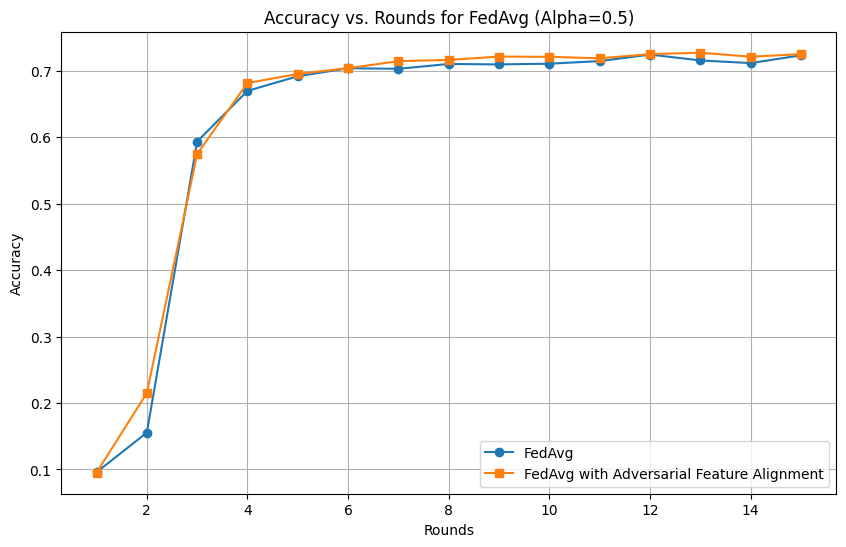

In [ ]:
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg)
alpha = 0.5
# accuracies = accuracies_per_alpha[alpha]
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg,round_accuracies_fedavg_adv)

# Extract the FedAvg and FedAvg Adv accuracies
plot_round_accuracies_fedavg = round_accuracies_fedavg_adv
plot_round_accuracies_fedavg_adv = round_accuracies_fedavg_adv_new

# Number of rounds
num_rounds = len(plot_round_accuracies_fedavg)
rounds = range(1, num_rounds + 1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, plot_round_accuracies_fedavg, label='FedAvg', marker='o')
plt.plot(rounds, plot_round_accuracies_fedavg_adv, label='FedAvg with Adversarial Feature Alignment', marker='s')

# Add labels, title, and legend
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Rounds for FedAvg (Alpha={alpha})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def run_scaffold_new(alpha):
    round_accuracies_fedavg, round_accuracies_fedavg_adv = 0, 0
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)

    global_model_fedavg_adv = SimpleCNN()
    _, round_accuracies_fedavg_adv = fedavg_training_new(
                                          global_model_fedavg_adv,
                                          train_loaders,
                                          num_clients,
                                          rounds=rounds,
                                          epochs=epochs,
                                          lr=lr,
                                          test_loaders=test_loaders,
                                          align= "SCAFFOLD")

    # global_model_fedavg_sc_adv = SimpleCNN()
    # _, round_accuracies_fedavg_adv = fedavg_training_new(
    #                                       global_model_fedavg_sc_adv,
    #                                       train_loaders,
    #                                       num_clients,
    #                                       rounds=rounds,
    #                                       epochs=epochs,
    #                                       lr=lr,
    #                                       test_loaders=test_loaders,
    #                                       align= "Adverserial")

    return round_accuracies_fedavg ,round_accuracies_fedavg_adv

alpha = 2
round_accuracies_fedavg_new, round_accuracies_fedavg_adv_new = run_scaffold_new(alpha)
# accuracies_per_alpha[alpha].append(round_accuracies_fedavg)

Communication Rounds:   7%|▋         | 1/15 [00:35<08:16, 35.45s/it]

Round 1 Accuracy: 0.0979



Communication Rounds:  13%|█▎        | 2/15 [01:11<07:45, 35.79s/it]

Round 2 Accuracy: 0.3957



Communication Rounds:  20%|██        | 3/15 [01:47<07:10, 35.90s/it]

Round 3 Accuracy: 0.6464



Communication Rounds:  27%|██▋       | 4/15 [02:23<06:34, 35.86s/it]

Round 4 Accuracy: 0.7032



Communication Rounds:  33%|███▎      | 5/15 [02:59<05:59, 35.91s/it]

Round 5 Accuracy: 0.7198



Communication Rounds:  40%|████      | 6/15 [03:35<05:23, 35.94s/it]

Round 6 Accuracy: 0.7295



Communication Rounds:  47%|████▋     | 7/15 [04:11<04:47, 35.95s/it]

Round 7 Accuracy: 0.7281



Communication Rounds:  53%|█████▎    | 8/15 [04:47<04:11, 35.93s/it]

Round 8 Accuracy: 0.7339



Communication Rounds:  60%|██████    | 9/15 [05:23<03:35, 35.92s/it]

Round 9 Accuracy: 0.7384



Communication Rounds:  67%|██████▋   | 10/15 [05:58<02:59, 35.92s/it]

Round 10 Accuracy: 0.7368



Communication Rounds:  73%|███████▎  | 11/15 [06:34<02:23, 35.92s/it]

Round 11 Accuracy: 0.7363



Communication Rounds:  80%|████████  | 12/15 [07:10<01:47, 35.91s/it]

Round 12 Accuracy: 0.7404



Communication Rounds:  87%|████████▋ | 13/15 [07:46<01:11, 35.90s/it]

Round 13 Accuracy: 0.7416



Communication Rounds:  93%|█████████▎| 14/15 [08:22<00:35, 35.90s/it]

Round 14 Accuracy: 0.7382



Communication Rounds: 100%|██████████| 15/15 [08:58<00:00, 35.90s/it]

Round 15 Accuracy: 0.7407


# with KL

In [ ]:
# Server-side Federated Averaging
def fedavg_training(adverserial, global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    discriminators = {}
    global_model = global_model.to(device)

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):

            if adverserial:
              client_id = i
              update = local_train_adversarial_kl(global_model, train_loaders[i], epochs, lr, client_id, discriminators)
            else:
              update = local_train(global_model, train_loaders[i], epochs, lr)

            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


# Client-side local training
def local_train(model, train_loader, epochs, lr):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    # for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels  = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update

def local_train_adversarial_kl(model, train_loader, epochs, lr, client_id, discriminators):
    """
    Train a local model with adversarial feature matching.

    Args:
        model (nn.Module): The global model to initialize local training.
        train_loader (DataLoader): DataLoader for the client's training data.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.
        client_id (int): Unique identifier for the client.
        discriminators (dict): Dictionary of discriminators for each client.

    Returns:
        dict: Dictionary of model updates (local model - global model).
    """
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()
    model.eval()  # Ensure the global model remains in evaluation mode

    criterion = nn.CrossEntropyLoss()
    adv_criterion = nn.KLDivLoss(reduction='batchmean')  # Loss for adversarial feature matching

    # Retrieve the discriminator for this client
    if client_id not in discriminators:
        # Initialize a new discriminator for this client if not already present
        discriminators[client_id] = Discriminator().to(device)  # Adjust input_size to match latent dimensions

    discriminator = discriminators[client_id]
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(local_model.parameters(), lr=lr)

    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            # Extract latents from both models
            global_latents = model.get_latents(data).detach()  # Detach to prevent gradient flow
            local_latents = local_model.get_latents(data)

            # Train Discriminator
            discriminator.train()
            real_preds = discriminator(global_latents)  # Real latents (from the global model)
            fake_preds = discriminator(local_latents.detach())  # Fake latents (from the local model)
            real_labels = torch.ones_like(real_preds).to(device)
            fake_labels = torch.zeros_like(fake_preds).to(device)

            d_loss_real = nn.BCELoss()(real_preds, real_labels)
            d_loss_fake = nn.BCELoss()(fake_preds, fake_labels)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Local Model (Generator)
            discriminator.eval()
            fake_preds = discriminator(local_latents)
            classification_loss = criterion(local_model(data), labels)
            adversarial_loss = -torch.mean(fake_preds)  # Generator tries to fool the discriminator

            # local_prob = torch.softmax(local_latents, dim=1)
            # global_prob = torch.softmax(global_latents, dim=1)

            # feature_matching_loss = adv_criterion(local_prob.log(), global_prob)

            total_loss = classification_loss + 0.1*adversarial_loss  # Adjust weights as needed
            # print(f"Classification Loss: {classification_loss.item()}, Adversarial Loss: {adversarial_loss.item()}")

            g_optimizer.zero_grad()
            total_loss.backward()
            g_optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update


In [ ]:
# HyperParameters
num_clients = 5
batch_size = 128
rounds = 15
epochs = 5
lr = 0.001
dirichlet_alphas = [0.5]

def run_fedavg(alpha):
    round_accuracies_fedavg, round_accuracies_fedavg_adv = 0, 0
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)

    Adverserial = True
    global_model_fedavg_adv = SimpleCNN()
    _, round_accuracies_fedavg_adv = fedavg_training(Adverserial,
                                          global_model_fedavg_adv,
                                          train_loaders,
                                          num_clients,
                                          rounds=rounds,
                                          epochs=epochs,
                                          lr=lr,
                                          test_loaders=test_loaders)

    return round_accuracies_fedavg_adv

In [ ]:
for alpha in [0.5,2]:
    round_accuracies_fedavg_adv = run_fedavg(alpha)

    if alpha not in accuracies_per_alpha:
        accuracies_per_alpha[alpha] = []
    accuracies_per_alpha[alpha].append(round_accuracies_fedavg_adv)

Clients Training (Round 1):  80%|████████  | 4/5 [00:57<00:15, 15.18s/it]

# To test Model Implementation// IGNORE

In [ ]:
import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm


def train_func(model, train_loader, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients before each step

        # Forward pass
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


def eval_func(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    # Don't compute gradients for evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


# Example usage:

# Assuming you have DataLoader objects `train_loader` and `test_loader` defined
# Also assuming you're using GPU or CPU, and the model is SimpleCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, optimizer, etc.
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate for a single epoch as an example
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model
    train_func(model, train_loader, optimizer, device)

    # Evaluate the model
    eval_func(model, test_loader, device)
